In [25]:
import numpy as np
import matplotlib.pyplot as plt

from __future__ import annotations
import numpy as np
from dataclasses import dataclass
from typing import Sequence, Dict, Tuple
from scipy.stats import lognorm
from numpy.linalg import solve
from numba import njit, float64, prange

import importlib
# --- Core code helpers ---
import src.core_helpers
importlib.reload(src.core_helpers)
from src.core_helpers import *

# --- Core Synthetic data ---
import src.core_SynData
importlib.reload(src.core_SynData)
from src.core_SynData import *

# --- Solvers ---
import src.core_Solvers
importlib.reload(src.core_Solvers)
from src.core_Solvers import *

# --- Energy Solvers ---
import src.core_ESolvers_norm
importlib.reload(src.core_ESolvers_norm)
from src.core_ESolvers_norm import *

#### VKU $P_{max}$ - $\beta$ relationship

In [26]:
VKU_Pmax = 126      # [MW]
VKU_beta_GL = 0.6196
VKU_beta_SL = 0.7157
s_ratio = (1/VKU_beta_SL) / VKU_Pmax
print(f"s_ratio: {s_ratio}")

s_ratio: 0.011089154585032747


### Simulation Parameters

In [27]:
# --- Simulation Parameters ---
N = 100_000_000
grid = 110000
Nystrom_grid = 1001

r = 0.01*60                 # 1/HR
tau = 0.0 
dt = 1/60                   # 1/HR
beta = 0.6               # min/MW
Pmax = (1/beta)/s_ratio
alpha = r*Pmax           # MW/HR]

a = alpha * dt           # MW
a_tilde = beta * a
print(f"Pmax: {Pmax}")
print(f"alpha value: {alpha} \na value: {a} \na_tilde value: {a_tilde}")

# --- Parameters for infinity limit ---
Pmax_inf = 10000000

# --- Simulation grid for P99 figures ---
r_values = np.linspace(0.1, 3.5, 50) / (beta * Pmax)    # [1/MIN]
alpha_values = r_values*60*Pmax                       # [MW/HR] (ALPHA)
a_values = alpha_values * dt                          # [MW/MIN]
a_tilde_values = beta * a_values
print(f"min(alpha_values): {min(alpha_values)}, max(alpha_values): {max(alpha_values)}")
print(f"min(a_values): {min(a_values)}, max(alpha_values): {max(a_values)}")
print(f"min(a_tilde_values): {min(a_tilde_values)}, max(a_tilde_values): {max(a_tilde_values)}")

Pmax: 150.297
alpha value: 90.17819999999999 
a value: 1.50297 
a_tilde value: 0.9017819999999999
min(alpha_values): 10.000000000000002, max(alpha_values): 350.00000000000006
min(a_values): 0.16666666666666669, max(alpha_values): 5.833333333333334
min(a_tilde_values): 0.1, max(a_tilde_values): 3.5000000000000004


### Synthetic Data

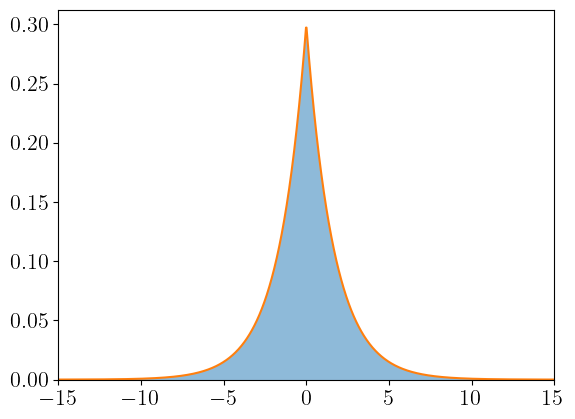

In [28]:
# --- SIMPLE LAPLACE TIME SERIES ---
# --- Taking P0 -> infinity ---
rng = np.random.default_rng(7)
seed = rng.random(N)
Y_inf, P_inf = simulate_Y_P_SL(N, Pmax_inf, 55, beta, seed)


x = np.linspace(-15, 15, 1000)
Y_analytical = 0.5*beta * np.exp(-np.abs(x)*beta)
plt.figure()
plt.hist(Y_inf, bins=1000, density=True, alpha=0.5, label='Y_inf')
plt.plot(x, Y_analytical, label='Analytical')
plt.xlim(-15, 15)
plt.show()

### Energy ramps: Simulation

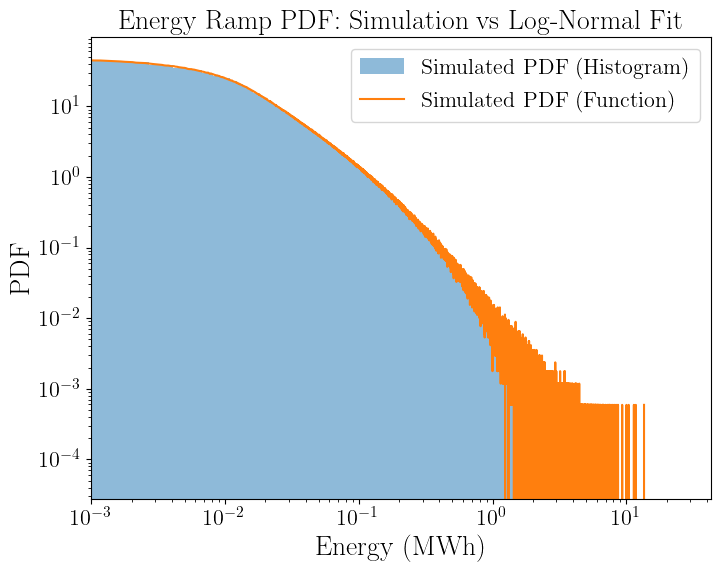

In [29]:
@dataclass(frozen=True)
class PDF:
    f: np.ndarray
    grid: np.ndarray

@dataclass(frozen=True)
class CDF:
    f: np.ndarray
    grid: np.ndarray

E, E_pdf, E_cdf, p99_sim = E_algorithmic_solution(a_tilde, beta, Y_inf, dt, grid, q=0.99)
E_pdf = PDF(*E_pdf)
E_cdf = CDF(*E_cdf)


plt.figure(figsize=(8,6))
plt.hist(E, bins=10000, density=True, alpha=0.5, label='Simulated PDF (Histogram)')
plt.plot(E_pdf.grid, E_pdf.f, label='Simulated PDF (Function)')
plt.title("Energy Ramp PDF: Simulation vs Log-Normal Fit")
plt.xlabel("Energy (MWh)")
plt.legend()
plt.ylabel("PDF")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-3, None)
plt.show()

### Log-normal fit

In [31]:
@dataclass(frozen=True)
class LogNormParams:
    mu: float
    sigma: float        # > 0
    scale: float        # exp(mu)
    e_grid: np.ndarray | None
    
params, LN_pdf, LN_cdf, p99 = E_LogNorm_solution_norm(a_tilde, dt, Nystrom_grid, E_pdf.grid, 1e-4, grid)
LN_params = LogNormParams(*params)

### Comparition: LogNormal fit vs Simulation

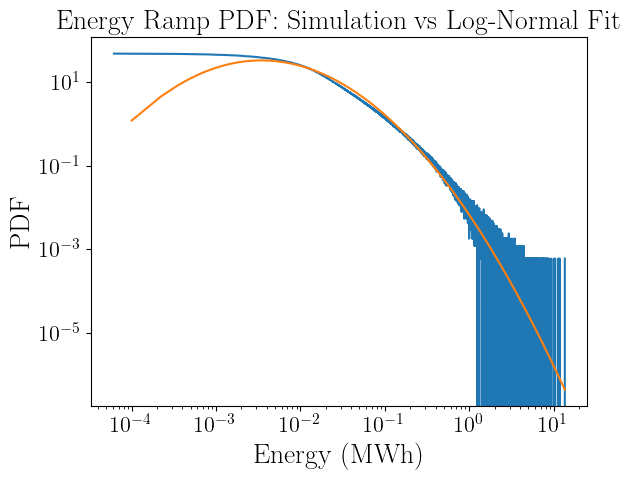

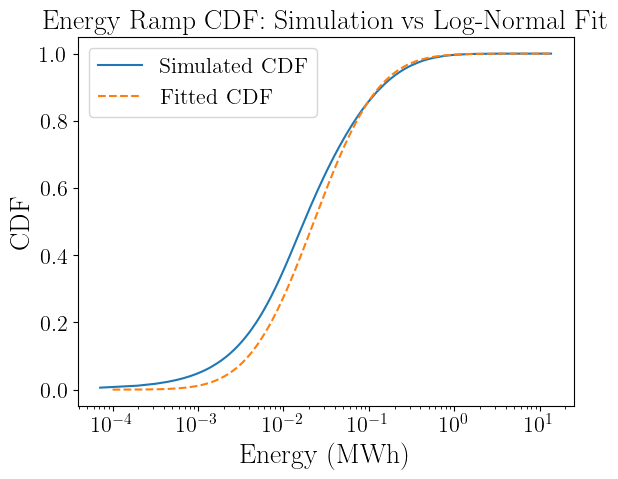

In [32]:
# --- PLOTTING COMPARISONS PDF/CDF --- 
plt.figure()
plt.plot(E_pdf.grid,  E_pdf.f, label='Simulated PDF')
plt.plot(LN_params.e_grid, LN_pdf, label='Log-Normal Fit', linewidth=1.5)
plt.title("Energy Ramp PDF: Simulation vs Log-Normal Fit")
plt.xlabel("Energy (MWh)")
plt.ylabel("PDF")
plt.xscale("log")
plt.yscale("log")
plt.show()

plt.figure()
plt.plot(E_cdf.grid, E_cdf.f, label='Simulated CDF')
plt.plot(LN_params.e_grid, LN_cdf, label='Fitted CDF', linestyle='--')
plt.title("Energy Ramp CDF: Simulation vs Log-Normal Fit")
plt.xlabel("Energy (MWh)")
plt.ylabel("CDF")
plt.legend() 
plt.xscale("log")
plt.show()

### How does L1 norm changes with the simulation resolution

In [ ]:
resolutions = np.arange(100_000_000, 900_000_000, 50_000_000)
L1_norm_error_values = []
for i, n in enumerate(resolutions):
    # --- Synthetic Data generation ---
    rng = np.random.default_rng(7)
    seed = rng.random(n)
    Y_inf, P_inf = simulate_Y_P_SL(n, Pmax_inf, 55, beta, seed)

    # --- Energy Algorithmic Solution ---
    E, E_pdf, E_cdf, p99_sim = E_algorithmic_solution(a, Y_inf, dt, grid, q=0.99)

    # --- Global Moments and Fit ---
    E1, E2 = Global_Moments(a, beta, dt, Nystrom_grid, 40.0)
    LN_params, LN_pdf, LN_cdf, p99_fit = E_LogNorm_solution_norm(E_pdf.grid, 1e-4, E1, E2, grid=grid)

    # --- L1 Error calculation ---
    norm = L1_norm(E_pdf.grid, E_pdf.f, LN_pdf)
    L1_norm_error_values.append (norm)

plt.figure()
plt.plot(resolutions, L1_norm_error_values, marker='o')
plt.title("L1 Norm Error between Simulated PDF and Log-Normal Fit")
plt.xlabel("Number of Simulated Samples")
plt.ylabel("L1 Norm Error")
plt.grid(True, alpha=0.3)
plt.show()

### Q-Q plot between algorihtmic and fitted solutions

C:\Users\Diego\AppData\Local\Temp\ipykernel_28944\2293315869.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p1 /= np.trapz(p1, x)
C:\Users\Diego\AppData\Local\Temp\ipykernel_28944\2293315869.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p2 /= np.trapz(p2, x)


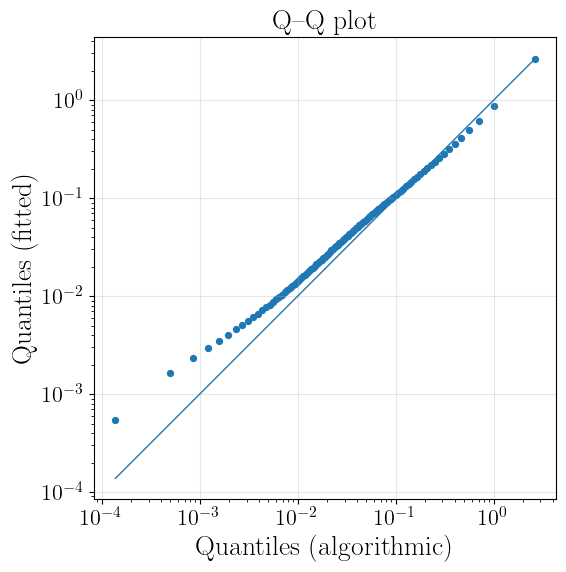

In [11]:
def qq_plot(x, pdf_alg, pdf_fit, n_quantiles):
    
    x = np.asarray(x, dtype=float).ravel()
    p1 = np.asarray(pdf_alg, dtype=float).ravel()
    p2 = np.asarray(pdf_fit, dtype=float).ravel()

    # basic consistency check
    if len(x) != len(p1) or len(x) != len(p2):
        raise ValueError("x, pdf_alg, and pdf_fit must have the same length")

    # sort by x
    s = np.argsort(x)
    x, p1, p2 = x[s], p1[s], p2[s]

    # clip negatives and normalize
    p1 = np.maximum(p1, 0.0)
    p2 = np.maximum(p2, 0.0)

    p1 /= np.trapz(p1, x)
    p2 /= np.trapz(p2, x)

    # build CDFs
    dx = np.diff(x)
    cdf1 = np.concatenate([[0.0], np.cumsum(0.5 * (p1[:-1] + p1[1:]) * dx)])
    cdf2 = np.concatenate([[0.0], np.cumsum(0.5 * (p2[:-1] + p2[1:]) * dx)])

    cdf1 /= cdf1[-1]
    cdf2 /= cdf2[-1]

    # quantiles (avoid extreme unstable tails automatically)
    eps = 1e-3
    probs = np.linspace(eps, 1 - eps, n_quantiles)

    q1 = np.interp(probs, cdf1, x)
    q2 = np.interp(probs, cdf2, x)

    # plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(q1, q2, s=18)

    lo = min(q1.min(), q2.min())
    hi = max(q1.max(), q2.max())
    ax.plot([lo, hi], [lo, hi], linewidth=1)

    ax.set_xlabel("Quantiles (algorithmic)")
    ax.set_ylabel("Quantiles (fitted)")
    ax.set_title("Q–Q plot")
    ax.set_aspect("equal", adjustable="box")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.grid(True, alpha=0.3)

    plt.show()

# --- 100_000_000 samples ---
E, E_pdf, E_cdf, p99_sim = E_algorithmic_solution(a, Y_inf, dt, grid, q=0.99)
E1, E2 = Global_Moments(a, beta, dt, Nystrom_grid, 40.0)
LN_params, LN_pdf, LN_cdf, p99_fit = E_LogNorm_solution(E_pdf.grid, 1e-4, E1, E2, grid=grid)
qq_plot(E_pdf.grid, E_pdf.f, LN_pdf, 100)

### INDEPENDENCE BETWEEN a AND $\beta$ for the p99 value 

In [ ]:
#  --- Simulation p99 values for different a_tilde values ---
p99_simVals = []
E_pdf_values = []
for i, a_tilde_val in enumerate(a_tilde_values):
    #a_val = a_values[i]
    _, E_pdf, _, p99_sim = E_algorithmic_solution(a_tilde_val, beta, Y_inf, dt, grid, q=0.99)
    p99_simVals.append(p99_sim)

print(f"p99_simVals completed")

# --- Fitting a curve to the P99 values ---
a_values_fit = np.linspace(min(alpha_values), max(alpha_values), 35) * dt
a_tilde_values_fit = beta * a_values_fit

p99_aTilde_Vals = []
for i in range(len(a_values_fit)-4):
    a_val = np.asarray([float(a_values_fit[i]), float(a_values_fit[i+1]), float(a_values_fit[i+2]), float(a_values_fit[i+3])+0.1])
    beta_val = np.asarray(a_tilde_values_fit[i]) / a_val
    a_tilde_ana = beta_val * (a_val)

    p99_fitVals = np.zeros(4)
    for j in range(4):
        a_j = a_val[j]
        beta_j = beta_val[j]
        a_tilde_value = beta_j * a_j

        # --- Analytical Solver ---
        #_, E_pdf, _, _ = E_algorithmic_solution(a_tilde_value, Y_inf, dt, grid, q=0.99)
        _, _, _, p99_fit = E_LogNorm_solution_norm(a_tilde_value, dt, Nystrom_grid, E_pdf[1], 1e-4, grid)
        p99_fitVals[j] = p99_fit
        
    p99_aTilde_Vals.append({"a": a_val, "beta": beta_val, "A_tilde": a_tilde_ana, "p99": p99_fitVals})

p99_simVals completed


NameError: name 'p99_fit' is not defined

In [15]:
# --- Algorithmic p99 curve ---
p99_simVals = []
E_pdf_values = []
for i, a_tilde_val in enumerate(a_tilde_values):
    #a_val = a_values[i]
    _, E_pdf, _, p99_sim = E_algorithmic_solution(a_tilde_val, Y_inf, dt, grid, q=0.99)
    p99_simVals.append(p99_sim)

In [16]:
# --- Fitting a curve to the P99 values ---
a_values_fit = np.linspace(min(alpha_values), max(alpha_values), 35, dtype=np.float64) * dt
a_tilde_values_fit = beta * a_values_fit

p99_aTilde_Vals = []
for i in range(len(a_values_fit)-4):
    a_val = np.asarray([a_values_fit[i], a_values_fit[i+1], a_values_fit[i+2], a_values_fit[i+3]])
    beta_val = np.asarray(a_tilde_values_fit[i]) / a_val
    a_tilde_ana = beta_val * (a_val)

    p99_LN_values = np.zeros(4)
    for i in range(4):
        a_value = a_val[i]; beta_value = beta_val[i]
        E1, E2 = Global_Moments(a_value, beta_value, dt, Nystrom_grid, 40.0)
        LN_params, LN_pdf, LN_cdf, p99_fit = E_LogNorm_solution(E_pdf.grid, 1e-4, E1, E2, grid=grid)
        # --- comparison values ---
        p99_LN_values[i] = p99_fit
    p99_aTilde_Vals.append({"a": a_val, "beta": beta_val, "A_tilde": a_tilde_ana, "p99": p99_LN_values})

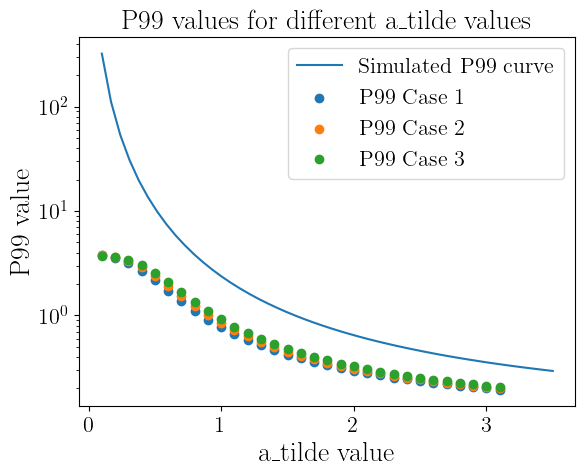

In [26]:
p99_case1 = np.array([item["p99"][0] for item in p99_aTilde_Vals])
p99_case2 = np.array([item["p99"][1] for item in p99_aTilde_Vals])
p99_case3 = np.array([item["p99"][2] for item in p99_aTilde_Vals])
a_tilde_cases = np.array([item["a"][0] * item["beta"][0] for item in p99_aTilde_Vals])

plt.figure()
plt.plot(a_tilde_values, p99_simVals, label='Simulated P99 curve')
plt.scatter(a_tilde_cases, p99_case1, label='P99 Case 1')
plt.scatter(a_tilde_cases, p99_case2, label='P99 Case 2')
plt.scatter(a_tilde_cases, p99_case3, label='P99 Case 3')
plt.title("P99 values for different a_tilde values")
plt.xlabel("a_tilde value")
plt.ylabel("P99 value")
plt.yscale("log")
plt.legend()
plt.show()

#### FIGURE 2: HOW DOES P99 CURVE COMPARISON CHANGES WITH A

In [1]:
# --- Fitting a curve to the P99 values ---
alpha_values_fit = np.linspace(min(alpha_values), max(alpha_values), 10)
a_values_fit = alpha_values_fit * dt
a_tilde_values_fit = beta * a_values_fit

p99_aTilde_Vals = []
for i in range(len(a_values_fit)-4):
    a_val = np.asarray([float(a_values_fit[i]), float(a_values_fit[i+1]), float(a_values_fit[i+2]), float(a_values_fit[i+3])+0.1])
    beta_val = np.asarray(a_tilde_values_fit[i]) / a_val
    a_tilde_ana = beta_val * (a_val); print(a_tilde_ana)

    p99_fitVals = np.zeros(4)
    for j in range(4):
        a_j = a_val[j]
        beta_j = beta_val[j]
        a_tilde_value = beta_j * a_j

        # --- Analytical Solver ---
        _, E_pdf, _, _ = E_algorithmic_solution(a_tilde_value, Y_inf, dt, grid, q=0.99)
        e1, e2 = Global_Moments(a_j, beta_j, dt, Nystrom_grid, 40.0)
        _, _, _, p99_fit = E_LogNorm_solution(E_pdf.grid, 1e-4, e1, e2, grid=grid)
        p99_fitVals[j] = p99_fit
        
    p99_aTilde_Vals.append({"a": a_val, "beta": beta_val, "A_tilde": a_tilde_ana, "p99": p99_fitVals})

NameError: name 'np' is not defined

#### Analyzing if the algorithmic p99 curve changes with a different a-$\beta$ combination

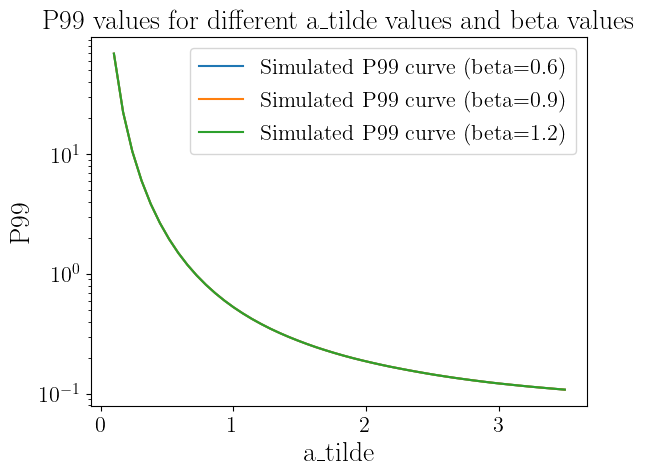

In [18]:
betas = [0.6, 0.9, 1.2]
a_values = alpha_values * dt
a_tilde_values = betas[0] * a_values

p99_simVals_cases = np.zeros((len(betas), len(a_values)))
for i, beta_case in enumerate(betas):
    a_values_case = a_tilde_values / beta_case
    a_tilde_values_case = beta_case * a_values_case
    Y_inf, _ = simulate_Y_P_SL(N, Pmax_inf, 55, beta_case, seed)
    
    p99_simVals_case = np.zeros(len(a_tilde_values_case))
    for j, a_tilde_val in enumerate(a_tilde_values_case):
        _, _, _, p99_sim_case = E_algorithmic_solution(a_tilde_val, beta_case, Y_inf, dt, grid, q=0.99)
        p99_simVals_case[j] = p99_sim_case
    p99_simVals_cases[i,:] = p99_simVals_case


plt.figure()
plt.plot(a_tilde_values, p99_simVals_cases[0,:], label='Simulated P99 curve (beta=0.6)')
plt.plot(a_tilde_values, p99_simVals_cases[1,:], label='Simulated P99 curve (beta=0.9)')
plt.plot(a_tilde_values, p99_simVals_cases[2,:], label='Simulated P99 curve (beta=1.2)')
plt.xlabel('a_tilde')
plt.ylabel('P99')
plt.legend()
plt.title("P99 values for different a_tilde values and beta values")
plt.yscale("log")
plt.show()

In [35]:
beta = 0.6
Y_inf, P_inf = simulate_Y_P_SL(N, Pmax_inf, 55, beta, seed)
E, E_pdf1, E_cdf, p99_sim = E_algorithmic_solution(a_val, Y_inf, dt, grid, q=0.99)

beta = 1
Y_inf, P_inf = simulate_Y_P_SL(N, Pmax_inf, 55, beta, seed)
E, E_pdf2, E_cdf, p99_sim = E_algorithmic_solution(a_val, Y_inf, dt, grid, q=0.99)
print(np.all(E_pdf1.grid == E_pdf2.grid))

False


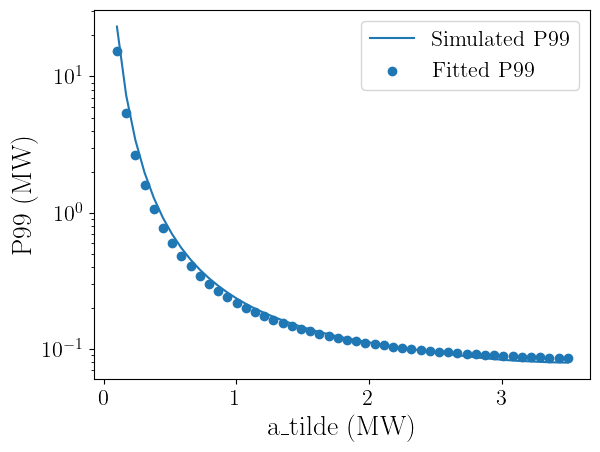

In [57]:
p99_sim_values = np.zeros(len(a_values))
p99_LN_values = np.zeros(len(a_values))
Epdf_grid_values = np.zeros(len(a_values))
e_grid = np.linspace(0.1, 1000, 100000)
norms = np.zeros(len(a_values))

beta = 1
Y_inf, P_inf = simulate_Y_P_SL(N, Pmax_inf, 55, beta, seed)

for i, a_val in enumerate(a_values):
    _, E_pdf, _, p99_sim = E_algorithmic_solution(a_val, Y_inf, dt, grid, q=0.99)
    E1, E2 = Global_Moments(a_val, beta, dt, Nystrom_grid, 40.0)
    _, LN_pdf, _, p99_fit = E_LogNorm_solution(E_pdf.grid, 1e-4, E1, E2, grid=grid)

    # --- comparison values ---
    p99_sim_values[i] = p99_sim
    p99_LN_values[i] = p99_fit
    Epdf_grid_values[i] = E_pdf.grid[-1]

plt.figure()
plt.plot(a_tilde_values, p99_sim_values, label='Simulated P99')
plt.scatter(a_tilde_values, p99_LN_values, label='Fitted P99')
plt.xlabel('a_tilde (MW)')
plt.ylabel('P99 (MW)')
plt.legend()
plt.yscale("log")
plt.show()

#### FIGURE 3: HOW DOES L1 NORM CHANGES WITH A

In [49]:
np.min(Epdf_grid_values)

np.float64(0.43805094852119186)

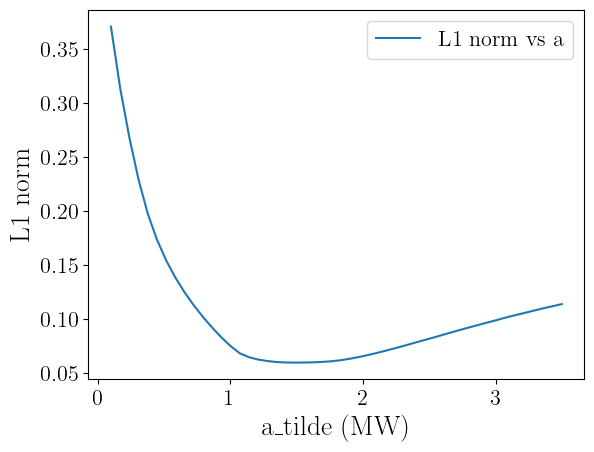

In [33]:
plt.figure()
plt.plot(a_tilde_values, norms, label='L1 norm vs a')
plt.xlabel('a_tilde (MW)')
plt.ylabel('L1 norm')
plt.legend()
#plt.ylim([0, 1])
plt.show()

### FIGURE 4: NUMBER OF RAMPS VS a_tilde value

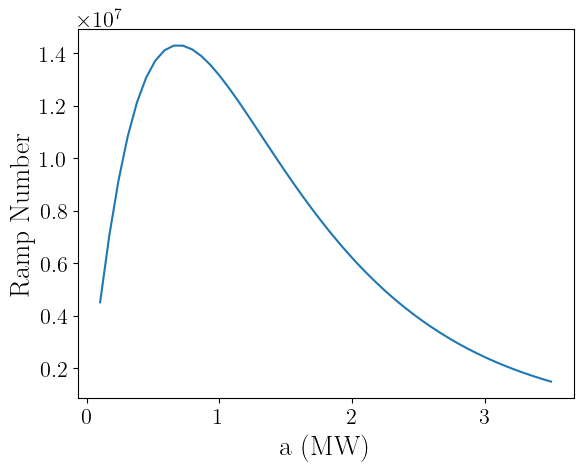

In [19]:
RampNumber_values = []
for a_val in a_values:
    E, E_pdf, E_cdf, p99_sim = E_algorithmic_solution(a_val, Y_inf, dt, grid, q=0.99)
    RampNumber_values.append(len(E))

plt.figure()
plt.plot(a_tilde_values,RampNumber_values)
plt.xlabel('a (MW)')
plt.ylabel('Ramp Number')
plt.show()